## DSMP J.P. Morgan Tape Data

## Contents

- [Load Data](#Load-Data)<br>
- [Data Cleaning](#Data-Cleaning)<br>
- [Transform Data](#Transform-Data)<br>
- [Features](#Features)<br>
- [EDA](#EDA)<br>
- [Strategy](#Strategy)<br>

## Load Data

__Data Description:__
- 125 csv, 3 columns
- Cols- Time, Price, Quantity

In [2]:
#import required libraries
import os
import pandas as pd
from datetime import datetime

In [3]:
#load data
path = 'C:/Users/s_sta/OneDrive/Desktop/DSMP/Tapes'
all_files = os.listdir(path)

#initialise empty df append all data
tape = pd.DataFrame()

In [4]:
#loop through each file in the directory
for file in all_files:
    if file.endswith('.csv'):
        #extract date from filename 
        date = file.split('_')[2].split('t')[0]

        #load csv file
        df = pd.read_csv(f'{path}/{file}')

        #add date col
        df['Date'] = pd.to_datetime(date)

        #set col names
        df.columns = ['Time', 'Price', 'Quantity', 'Date']

        #concatenate
        tape = pd.concat([tape, df], ignore_index=True)

In [5]:
tape.shape

(3340376, 4)

In [6]:
tape.head()

,Time,Price,Quantity,Date
0,11.067,269,1,2025-01-02
1,11.222,267,2,2025-01-02
2,12.338,270,2,2025-01-02
3,13.733,267,3,2025-01-02
4,18.321,265,2,2025-01-02


In [7]:
#save tape (in Jupyter env)
tape.to_csv('tape.csv', index=False)

- [Return to contents](#Contents)<br>

## Data Cleaning

__Missing Values__

In [8]:
#check for missing values
missing_values = tape.isnull().sum()

print("Missing Values:\n", missing_values)

Missing Values:
 Time        0
Price       0
Quantity    0
Date        0
dtype: int64


__Duplicate Rows__

In [9]:
#check for duplicate rows
duplicate_rows = tape.duplicated().sum()

print("Duplicate Rows:", duplicate_rows)

Duplicate Rows: 59827


We need to identify which duplicates are exact duplicates across all columns, and might indicate that the same transaction has been recorded or imported more than once. For these rows, removing the duplicates could be appropriate as they do not provide any additional information. If we are analysing trends over time, exact duplicates may skew our analysis by artificially inflating the volume or affecting the price representation. 

We also need to identify duplicates that are only partial, as this could indicate different trades that occurred at the same time or data errors. If our analysis focuses on the volume of trades, it's crucial to understand whether duplicates represent additional trades or mistakenly duplicated entries. Aggregating might be necessary if duplicates represent unique trades with only minor variations.

In [ ]:
#print("Shape before removing duplicates:", tape.shape)

In [ ]:
#remove duplicate rows
#tape.drop_duplicates(inplace=True)

In [ ]:
#print("Shape after removing duplicates:", tape.shape)

__Data Types__

In [10]:
#Do we need to change data types?
tape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340376 entries, 0 to 3340375
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Time      float64       
 1   Price     int64         
 2   Quantity  int64         
 3   Date      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 101.9 MB


In [11]:
#save clean tape (in Jupyter env)
tape.to_csv('tape.csv', index=False)

- [Return to contents](#Contents)<br>

## Transform Data

In [12]:
#import required libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np

In [13]:
#normalise- scaling data to range between 0 and 1
scaler = MinMaxScaler()
tape['Normalised_Price'] = scaler.fit_transform(tape[['Price']])

In [14]:
#standardise- scaling data to mean of 0 and standard deviation of 1)
scaler = StandardScaler()
tape['Standardised_Price'] = scaler.fit_transform(tape[['Price']])

In [15]:
tape.head()

,Time,Price,Quantity,Date,Normalised_Price,Standardised_Price
0,11.067,269,1,2025-01-02,0.578947,0.855046
1,11.222,267,2,2025-01-02,0.572368,0.830077
2,12.338,270,2,2025-01-02,0.582237,0.867531
3,13.733,267,3,2025-01-02,0.572368,0.830077
4,18.321,265,2,2025-01-02,0.565789,0.805109


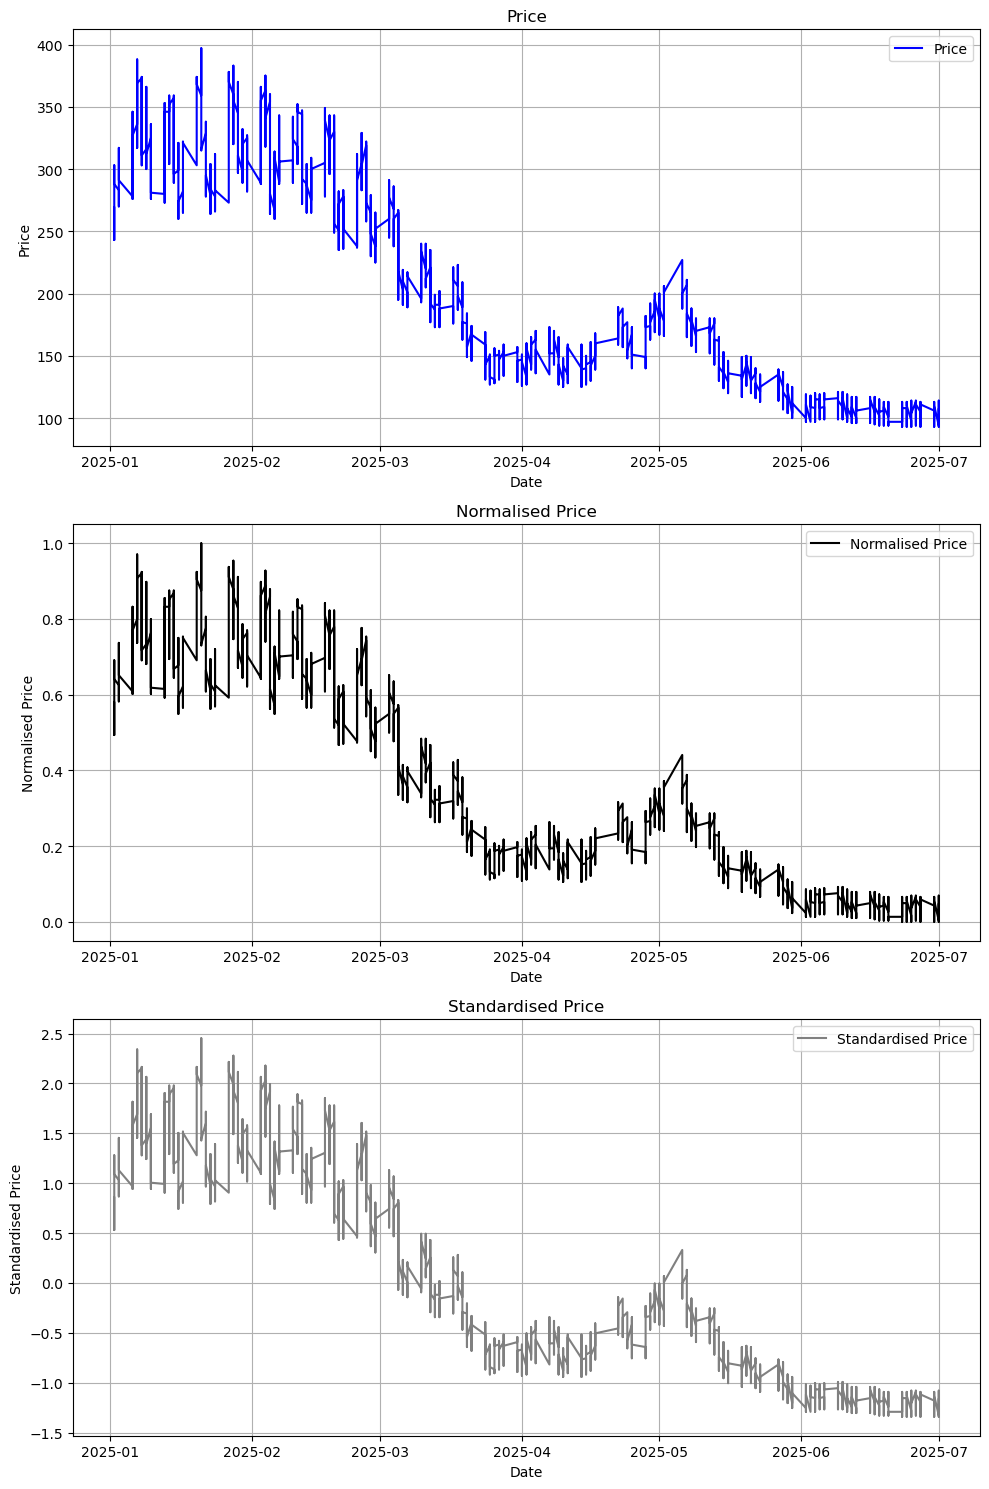

In [16]:
#visualise
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 15)) 

#price
axs[0].plot(tape['Date'], tape['Price'], label='Price', color='blue')
axs[0].set_title('Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid(True)

#normalised price
axs[1].plot(tape['Date'], tape['Normalised_Price'], label='Normalised Price', color='black')
axs[1].set_title('Normalised Price')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Normalised Price')
axs[1].legend()
axs[1].grid(True)

#standardised price
axs[2].plot(tape['Date'], tape['Standardised_Price'], label='Standardised Price', color='grey')
axs[2].set_title('Standardised Price')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Standardised Price')
axs[2].legend()
axs[2].grid(True)


plt.tight_layout()
plt.show()

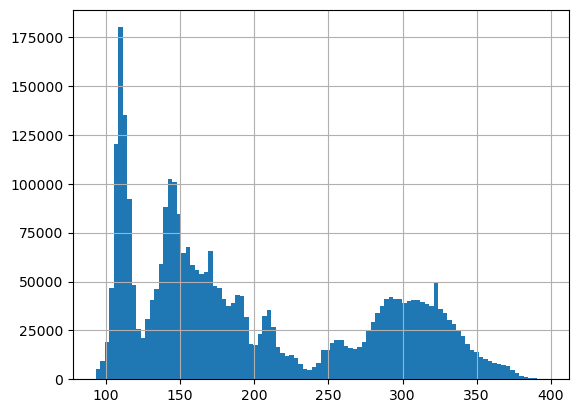

In [17]:
#histogram
tape['Price'].hist(bins=100) 
plt.show() 

In [ ]:
#we don't have open/high/low/close for a candlestick chart

In [18]:
#create a resample to daily so we can work out daily returns etc
#convert date to datetime format
tape['Date'] = pd.to_datetime(tape['Date'])
tape['TimeDelta'] = pd.to_timedelta(tape['Time'], unit='h')

#add timedelta to the Date to get a datetime column
tape['DateTime'] = tape['Date'] + tape['TimeDelta']
#set as the index
tape.set_index('DateTime', inplace=True)

#resample to daily frequency
daily_prices = tape.resample('D').agg({
    'Price': 'last',  #last price for the day (typical for closing price)
    'Quantity': 'sum',  #total quantity for the day
    'Normalised_Price': 'mean',  #average normalised price for the day
    'Standardised_Price': 'mean'  #average standardised price for the day
}) #drop date and timedelta by exclusiong

In [21]:
#save (in Jupyter env)
daily_prices.to_csv('daily_prices.csv', index=False)

In [22]:
#save transformed tape (in Jupyter env)
tape.to_csv('tape.csv', index=False)

- [Return to contents](#Contents)<br>

## Features

(using raw Price)

In [23]:
#daily returns
daily_prices['Daily_Return'] = daily_prices['Price'].pct_change() * 100

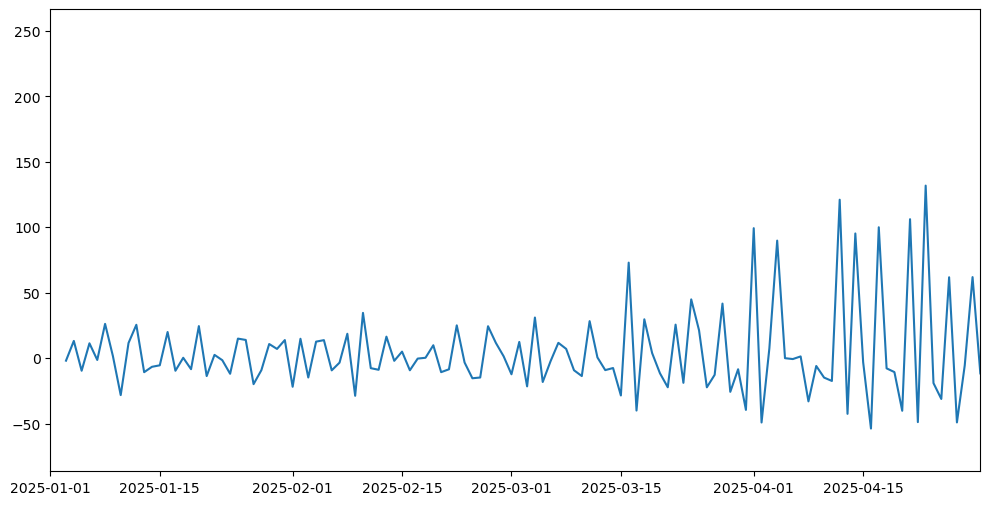

In [24]:
#visualise
plt.figure(figsize=(12, 6))
plt.xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-04-30')) #truncate to see patterns
plt.plot(daily_prices['Daily_Return'])
plt.show()

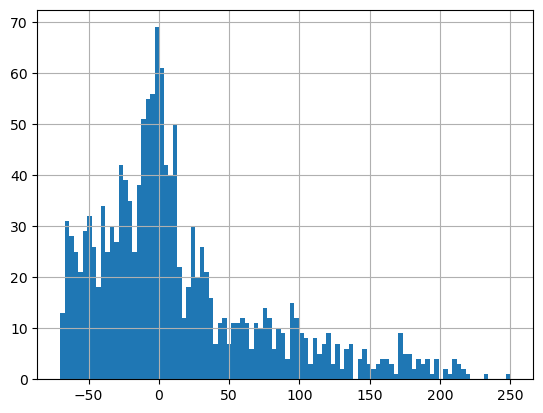

In [25]:
#histogram
daily_prices['Daily_Return'].hist(bins=100) 
plt.show() 

__What does this show?__<br>
Most of the daily returns cluster around a certain range, which seems to be centered slightly to the right of zero. This indicates that there might be a positive skew in the data, suggesting that there are more days with positive returns than negative. However, the center of the distribution is not clearly visible, so this is a cautious observation.

The spread of the returns gives an indication of the volatility of the stock. A wide spread indicates high volatility, while a narrow spread indicates low volatility.

There are bars far from the center, which could indicate outliers or extreme values in the returns. These might represent days with significant market events impacting the stock price.

The distribution does not appear to be perfectly normal as it shows a somewhat bimodal nature with two peaks. This could suggest that the stock has periods of different behaviors or that different factors are affecting the stock at different times.

__Technical Indicators__<br>
To reveal trends, momentum, and volatility.

In [26]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt

In [27]:
#simple moving average
#10 (short) and 50 (long) are standard meaures
#if we are interested in intraday trading (more granular)
tape['SMA_Short'] = tape['Price'].rolling(window=10).mean() 
tape['SMA_Long'] = tape['Price'].rolling(window=50).mean() 

#if we are focused on longer term trends and signals that span several days
daily_prices['SMA_Short'] = daily_prices['Price'].rolling(window=10).mean() 
daily_prices['SMA_Long'] = daily_prices['Price'].rolling(window=50).mean() 

#may want to calculate on weekly/monthly

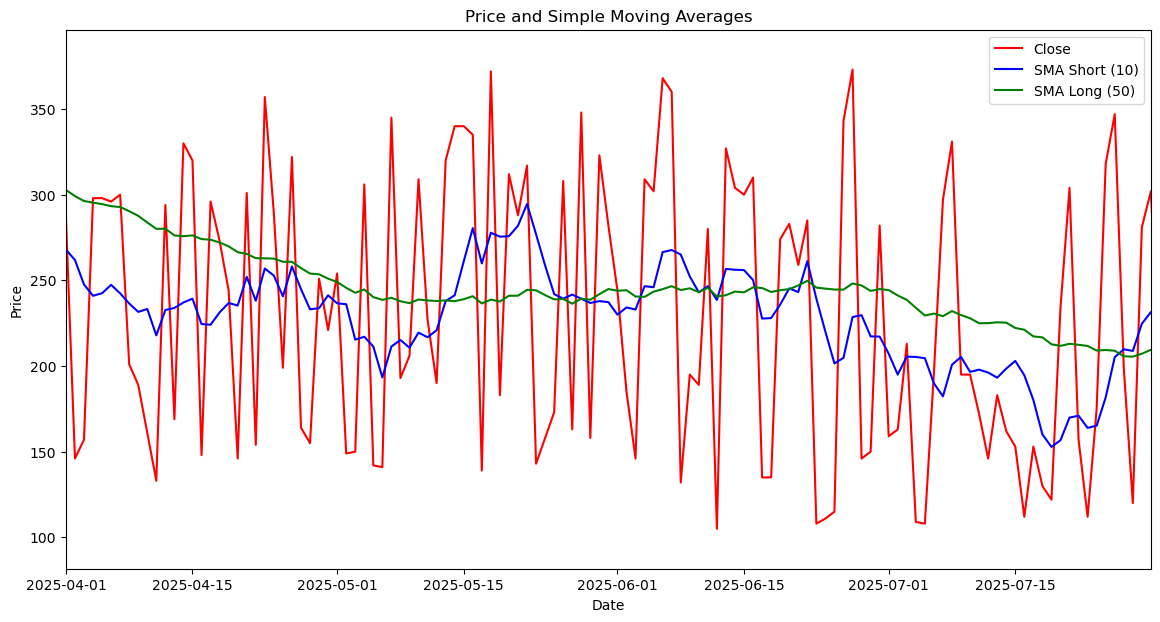

In [28]:
#visualise
plt.figure(figsize=(14, 7))

plt.plot(daily_prices.index, daily_prices['Price'], label='Close', color='red')
plt.plot(daily_prices.index, daily_prices['SMA_Short'], label='SMA Short (10)', color='blue')
plt.plot(daily_prices.index, daily_prices['SMA_Long'], label='SMA Long (50)', color='green')

plt.xlim(pd.Timestamp('2025-04-01'), pd.Timestamp('2025-07-30')) #truncate to see pattern
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and Simple Moving Averages')
plt.legend()

plt.show()

This can also be done with talib or pandas_ta packages
- https://pypi.org/project/TA-Lib/
- https://twopirllc.github.io/pandas-ta/

In [75]:
#pip install pandas_ta

In [29]:
import pandas as pd
import pandas_ta as ta

In [ ]:
#Can also do Exponential Moving Average (although more sensitive to most recent price movement )

In [ ]:
#bollinger bands
MA = tape['Price'].rolling(window=20).mean()
SD = tape['Price'].rolling(window=20).std()

tape['Upper_BB'] = MA + (2 * SD)  #upper bollinger band
tape['Lower_BB'] = MA - (2 * SD)  #lower bollinger band

In [ ]:
tape['Middle_BB'] = tape['Price'].rolling(window=20).mean()#middle bb

In [ ]:
#macd
EMA_12 = tape['Price'].ewm(span=12, adjust=False).mean()
EMA_26 = tape['Price'].ewm(span=26, adjust=False).mean()

tape['MACD'] = EMA_12 - EMA_26
tape['Signal_Line'] = tape['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
#relative strength index
delta = tape['Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss

tape['RSI'] = 100 - (100 / (1 + RS))

__Lag Features__<br>
To capture time based patterns and dependencies.

In [ ]:
#lag price
tape['Lagged_Price'] = tape['Price'].shift(1)  #previous day price

In [ ]:
#lag volume
tape['Lagged_Volume'] = tape['Quantity'].shift(1)  #previous day volume

__Window Statistics__<br> 
To helps in understanding local trends and volatility.

In [ ]:
#Rolling 7
tape['Rolling_Mean_7'] = tape['Price'].rolling(window=7).mean()

tape['Rolling_Median_7'] = tape['Price'].rolling(window=7).median()

tape['Rolling_Std_7'] = tape['Price'].rolling(window=7).std()

__Time Features__<br>
To identify seasonal patterns or time based trends.

In [ ]:
tape['Year'] = tape['Date'].dt.year
tape['Month'] = tape['Date'].dt.month
tape['Week'] = tape['Date'].dt.isocalendar().week
tape['Day'] = tape['Date'].dt.day
tape['DayOfWeek'] = tape['Date'].dt.dayofweek

__Volume-Weighted Average Price__<br> 
A trading benchmark that gives an average price a security has traded at throughout the day, based on both volume and price.

In [ ]:
tape['VWAP'] = (tape['Price'] * tape['Quantity']).cumsum() / tape['Quantity'].cumsum()

__Rate of Change__<br>
Measurement of the percentage change in price over a specified time period and can provide insight into the momentum of the stock.

In [ ]:
tape['Rate_of_Change'] = tape['Price'].pct_change(periods=1)  #change from previous day

__Fourier Transforms__<br>
To identify long term cycles and trends.

In [ ]:
FFT = np.fft.fft(np.asarray(tape['Price'].tolist()))
FFT_real = np.real(FFT)
tape['FFT'] = FFT_real

In [ ]:
#save (in Jupyter env)
daily_prices.to_csv('daily_prices.csv', index=False)

In [ ]:
#save tape with features (in Jupyter env)
tape.to_csv('tape.csv', index=False)

In [ ]:
#Are candlestick patterns appropriate? ta library offers a variety we could explore

- [Return to contents](#Contents)<br>

## EDA

In [ ]:
#import required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "notebook"

__Bollinger Bands__<br>
_Further Reading:_ https://www.investopedia.com/terms/b/bollingerbands.asp, https://towardsdev.com/python-trading-guide-bollinger-bands-111ccc318bdc

- Bollinger Bands® is a technical analysis tool to generate oversold or overbought signals and was developed by John Bollinger.
- Three lines compose Bollinger Bands: A simple moving average, or the middle band, and an upper and lower band.
- The upper and lower bands are typically 2 standard deviations +/- from a 20-day simple moving average and can be modified.
- When the price continually touches the upper Bollinger Band, it can indicate an overbought signal.
- If the price continually touches the lower band it can indicate an oversold signal.

In [ ]:
#set style & size
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

#olot price
plt.plot(tape['Date'], tape['Price'], label='Price', color='blue')

#plot bollinger bands
plt.plot(tape['Date'], tape['Upper_BB'], label='Upper Bollinger Band', linestyle='--', color='red')

plt.plot(tape['Date'], tape['Lower_BB'], label='Lower Bollinger Band', linestyle='--', color='green')

#labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and Bollinger Bands')
plt.legend()

plt.show()

In [ ]:
#set style & size
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

#olot price
plt.plot(tape['Date'], tape['Price'], label='Price', color='blue')

#plot bollinger bands
plt.plot(tape['Date'], tape['Upper_BB'], label='Upper Bollinger Band', linestyle='--', color='red')
plt.plot(tape['Date'], tape['Middle_BB'], label='Middle Bollinger Band', color='black')
plt.plot(tape['Date'], tape['Lower_BB'], label='Lower Bollinger Band', linestyle='--', color='green')

#labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and Bollinger Bands')
plt.legend()

plt.show()

In [ ]:
#can I make an interactive version?
#use plotly
#fig = go.Figure()

#price
#fig.add_trace(go.Scatter(x=tape['Date'], y=tape['Price'], mode='lines', name='Price'))

#upper and lower bb
#fig.add_trace(go.Scatter(x=tape['Date'], y=tape['Upper_BB'], mode='lines', name='Upper Bollinger Band',
                         #line=dict(color='red')))
#fig.add_trace(go.Scatter(x=tape['Date'], y=tape['Lower_BB'], fill='tonexty', mode='lines', name='Lower Bollinger Band',
                         #line=dict(color='green')))

#middle bb
#fig.add_trace(go.Scatter(x=tape['Date'], y=tape['Middle_BB'], mode='lines', name='Middle Bollinger Band',
                         #line=dict(color='blue')))

#fig.update_layout(title='Stock Price with Bollinger Bands',
                  #xaxis_title='Date',
                  #yaxis_title='Price',
                  #showlegend=True)
                  #xaxis=dict( #date slider (was taking really long to visualise -will revisit)
                      #rangeselector=dict(
                          #buttons=list([
                              #dict(count=1, label="1M", step="month", stepmode="backward"),
                              #dict(count=6, label="6M", step="month", stepmode="backward"),
                              #dict(count=1, label="YTD", step="year", stepmode="todate"),
                              #dict(count=1, label="1Y", step="year", stepmode="backward"),
                              #dict(step="all")
                          #])
                      #),
                      #rangeslider=dict(
                          #visible=True
                      #),
                      #type="date"
                  #))

#fig.show()

- [Return to contents](#Contents)<br>

## Strategy

https://pmorissette.github.io/bt/`

In [51]:
pip install bt

Note: you may need to restart the kernel to use updated packages.Collecting bt
     ------------------------------------- 215.6/215.6 kB 13.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 72.4/72.4 kB ? eta 0:00:00
     ---------------------------------------- 109.5/109.5 kB ? eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 26.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 2.2.0 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
spacy 3.2.4 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.10.12 which is incompatible.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.20 requires requests==2.28.1, but you have requests 2.31.0 which is incompatible.


In [52]:
#import required libraries
import bt

C:\Users\s_sta\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [67]:
#df for testing (just datetime and price(daily resampled is most commonly used))
testing = daily_prices[['Price']].copy() #datetime is index

In [68]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1455 entries, 2025-01-02 to 2028-12-26
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Price   1455 non-null   int64
dtypes: int64(1)
memory usage: 22.7 KB


In [ ]:
#save (in Jupyter env)
testing.to_csv('testing.csv', index=False)

In [69]:
#define strategy (test)
bt_strategy = bt.Strategy('Trade_Weekly', 
[bt.algos.RunWeekly(), #run weekly 
bt.algos.SelectAll(), #use all data 
bt.algos.WeighEqually(), #maintain equal weights 
bt.algos.Rebalance()]) #rebalance 

In [70]:
#create backtest 
bt_test = bt.Backtest(bt_strategy, testing) 
#run backtest 
bt_res = bt.run(bt_test)

<AxesSubplot:title={'center':'Backtest result'}>

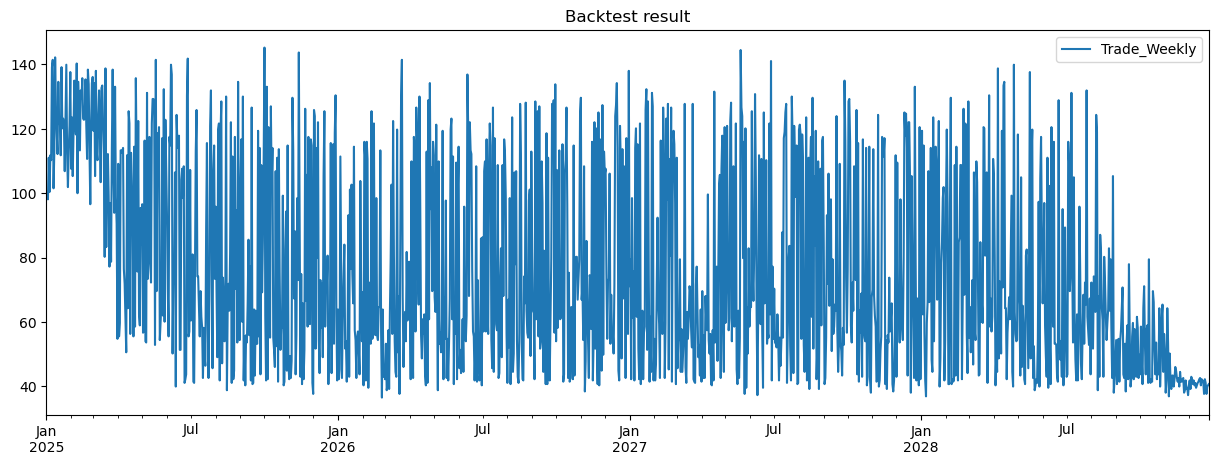

In [71]:
#plot the result 
bt_res.plot(title="Backtest result") 

In [ ]:
#Shows this would be a negative strategy to use

In [72]:
#get trade details 
bt_res.get_transactions()

,,price,quantity
Date,Security,,
2025-01-02,Price,263.0,3802.0


- [Return to contents](#Contents)<br>